Độ chính xác của mô hình: 100.00%
Cây quyết định:
Node: If petal length (cm) <= 1.90
  True:
    Leaf: 0
  False:
    Node: If petal width (cm) <= 1.70
      True:
        Node: If sepal length (cm) <= 7.00
          True:
            Leaf: 1
          False:
            Leaf: 2
      False:
        Node: If petal length (cm) <= 4.80
          True:
            Leaf: 2
          False:
            Leaf: 2


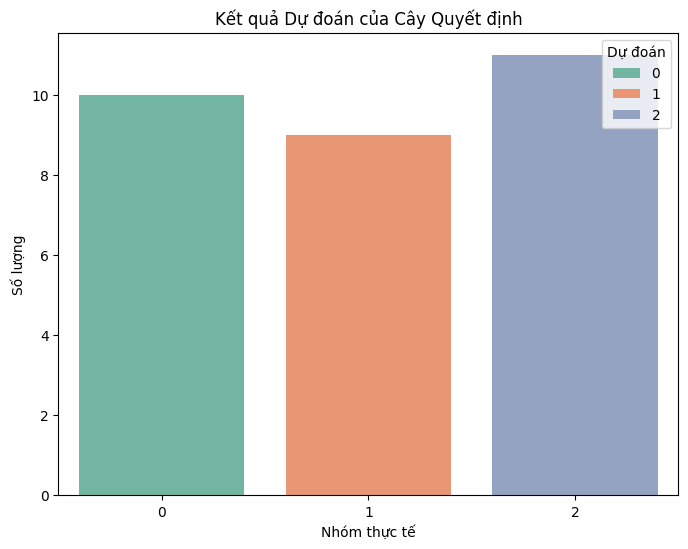

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# hàm chia node thành 2 node con dựa trên ngưỡng
def split_node(column, threshold_split):
    left_node = column[column <= threshold_split].index
    right_node = column[column > threshold_split].index
    return left_node, right_node

# hàm tính entropy
def entropy(y_target):
    values, counts = np.unique(y_target, return_counts=True)
    result = -np.sum([(count / len(y_target)) * np.log2(count / len(y_target)) for count in counts])
    return result

# hàm tính information gain
def info_gain(column, target, threshold_split):
    entropy_start = entropy(target)
    left_node, right_node = split_node(column, threshold_split)
    n_left = len(left_node)
    n_right = len(right_node)
    entropy_left = entropy(target[left_node])
    entropy_right = entropy(target[right_node])
    weight_entropy = (n_left / (n_left + n_right)) * entropy_left + (n_right / (n_left + n_right)) * entropy_right
    ig = entropy_start - weight_entropy
    return ig

# hàm tìm feature và threshold tốt nhất để chia
def best_split(dataX, target, feature_id):
    best_ig = -1
    best_feature = None
    best_threshold = None
    for _id in feature_id:
        column = dataX.iloc[:, _id]
        thresholds = set(column)
        for threshold in thresholds:
            ig = info_gain(column, target, threshold)
            if ig > best_ig:
                best_ig = ig
                best_feature = dataX.columns[_id]
                best_threshold = threshold
    return best_feature, best_threshold

# hàm lấy giá trị xuất hiện nhiều nhất trong node lá
def most_value(y_target):
    value = y_target.value_counts().idxmax()
    return value

# lớp Node đại diện cho từng node trong cây
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

# lớp Decision Tree Classification
class DecisionTreeClass:
    def __init__(self, min_samples_split=2, max_depth=10, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        self.n_features = n_features

    def grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_classes = len(np.unique(y))

        if depth >= self.max_depth or n_classes == 1 or n_samples < self.min_samples_split:
            leaf_value = most_value(y)
            return Node(value=leaf_value)

        feature_id = np.random.choice(n_feats, self.n_features, replace=False)
        best_feature, best_threshold = best_split(X, y, feature_id)

        left_node, right_node = split_node(X[best_feature], best_threshold)

        left = self.grow_tree(X.loc[left_node], y.loc[left_node], depth + 1)
        right = self.grow_tree(X.loc[right_node], y.loc[right_node], depth + 1)

        return Node(best_feature, best_threshold, left, right)

    def fit(self, X, y):
        self.n_features = X.shape[1] if self.n_features is None else min(X.shape[1], self.n_features)
        self.root = self.grow_tree(X, y)

    def traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)

    def predict(self, X):
        return np.array([self.traverse_tree(x, self.root) for index, x in X.iterrows()])

# Hàm để in cây quyết định
def print_tree(node, indent=""):
    if node.is_leaf_node():
        print(f"{indent}Leaf: {node.value}")
        return

    print(f"{indent}Node: If {node.feature} <= {node.threshold:.2f}")

    print(f"{indent}  True:")
    print_tree(node.left, indent + "    ")

    print(f"{indent}  False:")
    print_tree(node.right, indent + "    ")

# hàm tính độ chính xác
def accuracy(y_actual, y_pred):
    acc = np.sum(y_actual == y_pred) / len(y_actual)
    return acc * 100

# Hàm để vẽ biểu đồ kết quả
def plot_results(y_test, y_pred):
    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    plt.figure(figsize=(8, 6))
    sns.countplot(data=results_df, x='Actual', hue='Predicted', palette='Set2')
    plt.title('Kết quả Dự đoán của Cây Quyết định')
    plt.xlabel('Nhóm thực tế')
    plt.ylabel('Số lượng')
    plt.legend(title='Dự đoán', loc='upper right')
    plt.show()

# Ví dụ sử dụng với tập dữ liệu Iris
if __name__ == "__main__":
    # Tải tập dữ liệu Iris
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = pd.Series(iris.target)

    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Khởi tạo và huấn luyện mô hình
    model = DecisionTreeClass(min_samples_split=2, max_depth=3, n_features=2)
    model.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Tính và in độ chính xác
    acc = accuracy(y_test, y_pred)
    print(f"Độ chính xác của mô hình: {acc:.2f}%")

    # In cây quyết định
    print("Cây quyết định:")
    print_tree(model.root)

    # Vẽ biểu đồ kết quả
    plot_results(y_test, y_pred)
